In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import torch
from torch import nn
import torch.nn.functional as f

from utils import flat_to_triangular, make_cholesky, plot, clean_curr_axes, onehot, log_sum_exp

np.random.seed(3)

## Classification: NN with Bayesian last linear layer

### Problem

We consider a classification problem with $K$ classes, inputs $\mathbf{x}$, and target classes $\mathbf{t}$, where each target $t_i$ is a scalar denoting the class of $x_i$. We wish to learn a bayesian linear model with learnt basis functions, and take the output of such model as score for the different classes.

### Known basis function

In the case of a known deterministic $D$-dimensional basis function $\phi$, the predicted probability for the different classes for example $x_i$ is:

\begin{align}
    \mathbf{y} = \mathrm{softmax} (\mathbf{a} \phi(x_i) + \mathbf{b})
\end{align}

where $\mathbf{y}$ and $\mathbf{b}$ are $K$-vectors, $\mathbf{a}$ is a $K \times D$ matrix, and the softmax is computed over the $K$ classes.
The likelihood of a data point $(x_i, t_i)$ is:

\begin{align}
p(t_i \ |\ \mathbf{a}, \mathbf{b}, x_i) & = y[t_i]
\end{align}

i.e. the model output for the true class $t_i$. Assuming independence, the likelihood of the parameters given the entire dataset is simply the product of the above.

We define the prior over the parameters as an isotropic Gaussian, which gives:

\begin{align}
 p(\mathbf{a}) = \mathcal{N}(0,\mathbf{I}) \qquad  p(\mathbf{b}) = \mathcal{N}(0,\mathbf{I})
\end{align}

The posterior of the parameters, with $(\mathbf{x}, \mathbf{t})$ the entire dataset, is:

\begin{align}
p(\mathbf{a}, \mathbf{b} \ |\ \mathbf{t} , \mathbf{x}) = \frac{p(\mathbf{t}\ |\ \mathbf{a}, \mathbf{b}, \mathbf{x}) p(\mathbf{a}, \mathbf{b})}{p(\mathbf{t} \ |\ \mathbf{x})}
\end{align}

The denominator $p(\mathbf{t} | \mathbf{x})$ is tractable and constant, hence we can also approximate the posterior using our favorite MCMC methods.


### Learnt basis function

#### Bayes by Backprop

Let $\mathbf{w}$ be the vector with all the parameters $\mathbf{a}$ and $\mathbf{b}$, having size $D' = (D+1)K$. As basis function we use $f_\theta$, a neural network parameterized by a vector $\theta$. This effectively corresponds to a neural network where the last layer is Bayesian.

We approximate the posterior parameter distribution $p(\mathbf{w} \ |\ \mathcal{D})$ with

$$q(\mathbf{w}) = \mathcal{N}(\boldsymbol{\mu}_{\mathbf{w}}, \boldsymbol{\Sigma}_{\mathbf{w}})$$

and optimize this distribution with variational inference, whereas $\theta$ is estimated by maximum likelihood. We do this by deriving a lower bound of the marginal log likelihood that we can optimize end-to-end with respect to $\theta$, $\boldsymbol{\mu}_{\mathbf{w}}$, and $ \boldsymbol{\Sigma}_{\mathbf{w}}$. We have:

\begin{align}
\log p(\mathbf{t} | \mathbf{x};\theta) & = \log \int_{\mathbf{a},\mathbf{b}} p(\mathbf{t}, \mathbf{a}, \mathbf{b} | \mathbf{x};  \theta) d\mathbf{a} d\mathbf{b} \\
& = \log \int_{\mathbf{a},\mathbf{b}} p(\mathbf{t} | \mathbf{a}, \mathbf{b}, \mathbf{x};  \theta)p(\mathbf{a},\mathbf{b}) d\mathbf{a} d\mathbf{b} \\
& = \log \int_{\mathbf{a},\mathbf{b}} q(\mathbf{a},\mathbf{b}) p(\mathbf{t} | \mathbf{a}, \mathbf{b}, \mathbf{x};  \theta) \frac{p(\mathbf{a},\mathbf{b})}{q(\mathbf{a},\mathbf{b})} d\mathbf{a} d\mathbf{b} \\
& \geq \mathbb{E}_{q(\mathbf{a},\mathbf{b})} \left[ \log  p(\mathbf{t} | \mathbf{a},\mathbf{b}, \mathbf{x}; \theta) \frac{p(\mathbf{a},\mathbf{b})}{q(\mathbf{a},\mathbf{b})} \right] \\
& = \mathbb{E}_q[\log p(\mathbf{t}\ |\ \mathbf{a},\mathbf{b}, \mathbf{x}; \theta)] - \mathrm{KL}(q(\mathbf{a},\mathbf{b}) \ ||\ p(\mathbf{a},\mathbf{b})) \\
&= \mathcal{L (\mathbf{t},\mathbf{x})}
\end{align}

#### Modelling the posterior of vector quantities with covariance

We choose to model the approximate posterior of $\mathbf{w}$ using a **Multivariate Gaussian** where the covariance matrix $\boldsymbol{\Sigma}$ is parametrized by using the Cholesky decomposition $\boldsymbol{\Sigma}=\mathbf{L}\mathbf{L}^T$, which allows us to apply the reparametrization trick [[Pathwise Derivatives Beyond the Reparameterization Trick]](https://arxiv.org/pdf/1806.01851.pdf):

\begin{align}
\mathbf{y} = \boldsymbol{\mu} + \mathbf{L} \boldsymbol{\epsilon}, \quad 
\boldsymbol{\epsilon} \sim \mathcal{N}(0, \mathbf{I}) \quad \Rightarrow \quad
\mathbf{y} \sim \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\Sigma})
\end{align}

where we can easily see that the mean of $\mathbf{y}$ is $\boldsymbol{\mu}$, and the covariance is indeed $\boldsymbol{\Sigma}$:

\begin{aligned}
\mathrm{cov} (\mathbf{y}) &=\mathbb{E}\left[(\mathbf{y}-\mathbb{E}[\mathbf{y} ])(\mathbf{y}-\mathbb{E}[\mathbf{y} ])^{T}\right] \\ 
&=\mathbb{E}\left[\mathbf{L} \boldsymbol{\epsilon}(\mathbf{L} \boldsymbol{\epsilon})^{T}\right] \\ 
&=\mathbb{E}\left[\mathbf{L} \boldsymbol{\epsilon} \boldsymbol{\epsilon}^{T} \mathbf{L}^{T}\right] \\ 
&=\mathbf{L} \mathbb{E}\left[\boldsymbol{\epsilon} \boldsymbol{\epsilon}^{T}\right] \mathbf{L}^{T} \\ 
&=\mathbf{L} \mathbf{L}^{T} = \boldsymbol{\Sigma}
\end{aligned}


The two terms we need to compute the ELBO are as follows:

\begin{split}
\mathbb{E}_q[\log p(\mathbf{t}\ |\ \mathbf{w}, \mathbf{x} ; \theta)] &=  \mathbb{E}_q \left[ \sum_{i = 1}^N \log p(t_i \ |\ \mathbf{w}, x_i) \right] = \mathbb{E}_q \left[ \sum_{i = 1}^N \log y[t_i] \right] \\
\mathrm{KL}(q(\mathbf{w}) \ ||\ p(\mathbf{w})) &= -\frac{1}{2} \sum_{i=1}^{D'} \left(1 + \log L_{i,i}^2 - \mu_i^2 - \Sigma_{i,i}\right)
\end{split}

where $N$ is the data set size. Here we used the KL divergence between multivariate Gaussian distributions:

\begin{aligned}
\mathrm{KL}(q\ ||\ p)
    &= \frac{1}{2} \left( \log |\boldsymbol{\Sigma}_ p| - \log |\boldsymbol{\Sigma}_ q| - D' + \mathrm{tr} (\boldsymbol{\Sigma}_p^{-1} \boldsymbol{\Sigma}_q) + (\boldsymbol{\mu}_p - \boldsymbol{\mu}_q)^T  \boldsymbol{\Sigma}_p (\boldsymbol{\mu}_p - \boldsymbol{\mu}_q)\right) \\
    & = \frac{1}{2} \left( - \log \left(|\boldsymbol{L}|^2\right) - D' + \mathrm{tr} (\boldsymbol{\Sigma}_q) +  \boldsymbol{\mu}_q^T \boldsymbol{\mu}_q\right) \\
    & = -\frac{1}{2} \left(D' + \sum_{i=1}^{D'} \log L_{ii}^2 - \sum_{i=1}^{D'} (\boldsymbol{\Sigma}_q)_{ii} - \sum_{i=1}^{D'} (\boldsymbol{\mu}_q)_i^2 \right)
\end{aligned}

### Papers

[Gaussian variational approximation with a factor covariance structure](https://arxiv.org/pdf/1701.03208.pdf)

[Pathwise Derivatives Beyond the Reparameterization Trick](https://arxiv.org/pdf/1806.01851.pdf)

[Berkley Kingma ppt](https://berkeley-deep-learning.github.io/cs294-131-s17/slides/VAE%20talk.compressed.pdf)

### Toy Dataset


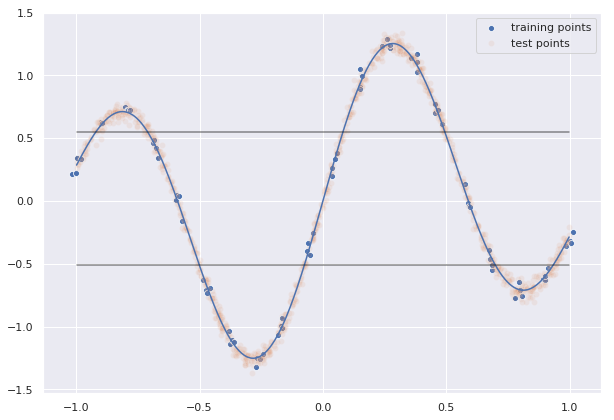

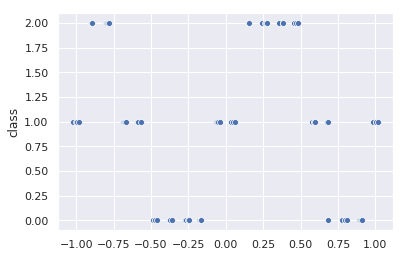

x shape: (80, 1)
x test shape: (1000, 1)
t shape: (80, 3)
t_values shape: (80,)


In [2]:
N = 80    # data points
duplicate_factor = 4
duplicate_sigma = 0.01
N_test = 1000  # test data points
sigma = .04  # final noise
n_classes = 3

## Random data points
# x = np.random.rand(N + N_test, 1) * 2 - 1

## Random clusters of data points
x = np.linspace(-1.0, 1.0, N//duplicate_factor).reshape(-1, 1)
# x = np.random.rand(N//duplicate_factor, 1) * 2 - 1
noise = np.random.randn(N//duplicate_factor, duplicate_factor) * duplicate_sigma
x = x + noise
x = x.reshape(N, 1)

x_test = np.random.rand(N_test, 1) * 2 - 1

x = np.concatenate((x_test, x), axis=0)

fx = -x**3 + x + np.sin(6 * x)
noisy_fx = fx + sigma*np.random.randn(*x.shape)  # function to compute labels

# Divide data interval in n_classes regions
# thresholds = np.linspace(tmp.min() - 1e-3, tmp.max() + 1e-3, n_classes+1)  # equal size
thresholds = np.percentile(noisy_fx, np.linspace(0, 100, n_classes+1))  # balanced classes

# targets
t = np.zeros((noisy_fx.shape[0], n_classes), dtype=int)  # one-hot, shape (N, C)
for i in range(n_classes):
    t[:, i] = ((thresholds[i] < noisy_fx) * (thresholds[i+1] >= noisy_fx))[:, 0]
t_values = t * np.arange(n_classes).reshape((1, -1))
t_values = np.sum(t_values, 1)

x_test = x[:N_test]
x = x[N_test:]
fx_test = fx[:N_test]
fx = fx[N_test:]
noisy_fx_test = noisy_fx[:N_test]
noisy_fx = noisy_fx[N_test:]
t_test = t[:N_test]
t = t[N_test:]
t_values_test = t_values[:N_test]
t_values = t_values[N_test:]

test_sort_idx = np.argsort(x_test, axis=0).flatten()
x_test, fx_test, noisy_fx_test, t_test, t_values_test = (
    tensor[test_sort_idx] for tensor in [x_test, fx_test, noisy_fx_test, t_test, t_values_test])
sort_idx = np.argsort(x, axis=0).flatten()
x, fx, noisy_fx, t, t_values = (tensor[sort_idx] for tensor in [x, fx, noisy_fx, t, t_values])


# Plot continuous data and class thresholds
plt.figure(figsize=(10, 7))
plt.plot(x_test, fx_test)
sns.scatterplot(x[:, 0], noisy_fx[:, 0], label='training points')
sns.scatterplot(x_test[:, 0], noisy_fx_test[:, 0], alpha=0.1, label='test points')
for i in range(1, n_classes):
    plt.plot([x_test[0], x_test[-1]], np.array([1., 1.]) * thresholds[i], color='k', alpha=0.5)
plt.legend()
plt.show()

# Plot class distribution
sns.scatterplot(x[:, 0], t_values)
plt.ylabel('class')
plt.show()


# # Plot continuous data and class thresholds: test data
# plt.figure(figsize=(10, 7))
# plt.plot(x_test, fx_test)
# sns.scatterplot(x_test[:, 0], noisy_fx_test[:, 0])
# for i in range(1, n_classes):
#     plt.plot([x_test[0], x_test[-1]], np.array([1., 1.]) * thresholds[i], color='k', alpha=0.5)
# plt.show()



print('x shape:', x.shape)
print('x test shape:', x_test.shape)

print('t shape:', t.shape)
print('t_values shape:', t_values.shape)

x = torch.tensor(x, dtype=torch.float)
t_values = torch.tensor(t_values, dtype=torch.long)
x_test = torch.tensor(x_test, dtype=torch.float)
t_values_test = torch.tensor(t_values_test, dtype=torch.long)

### Features extractor and stochastic layer


In [3]:
last_layer_size = 16
a_shape = (last_layer_size, n_classes)  # shape of stochastic weight matrix
a_size = np.prod(a_shape)
b_size = n_classes

class FeaturesExtractor(nn.Module):
    def __init__(self, n_out, use_dropout=False):
        super().__init__()
        if use_dropout:
            self.layers = nn.Sequential(
                nn.Linear(1, 64), nn.LeakyReLU(),
                #nn.Dropout(0.4),
                nn.Linear(64, 64), nn.LeakyReLU(),
                #nn.Dropout(0.4),
                nn.Linear(64, n_out))
        else:
            self.layers = nn.Sequential(
                nn.Linear(1, 32), nn.LeakyReLU(),
                nn.Linear(32, n_out))
        
    def forward(self, x):
        return self.layers(x)
    
    
class CovarianceStochasticLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, mu_q, cholesky):
        eps = torch.randn_like(mu_q)
        return mu_q + cholesky @ eps
    
    def forward_diagonal(self, mu_q, logvar_q):
        eps = torch.randn_like(mu_q)
        std = (logvar_q/2).exp()
        return mu_q + std * eps

    # def get_kl(self, mu_q, logvar_q):
    #     kl = -0.5 * (1 + logvar_q - mu_q.pow(2) - logvar_q.exp())
    #     return kl.sum()
    def get_kl(self, mu_q, L_logdiag_q, L_q):
        kl = -0.5 * (1 + L_logdiag_q - mu_q.pow(2) - torch.diag(L_q @ L_q.permute(1, 0)))
        #print(L_logdiag_q.sum().item(), mu_q.pow(2).sum().item(), torch.diag(L_q @ L_q.permute(1, 0)).sum().item())
        return kl.sum()


### Optimize

Here we maximize the ELBO $\mathcal{L}$ with respect to the variational parameters $\boldsymbol{\mu}_{\mathbf{w}}$ and $\boldsymbol{\Sigma}_{\mathbf{w}}$, and the NN parameters $\theta$.

First we train the model with ML (no sampling, just train means), then compare with the Bayesian one.

We also estimate the marginal predictive log-likelihood as:

\begin{aligned}
\log p(\mathbf{t} | \mathbf{x}, \mathcal{D}; \theta) & = \log \int_{\mathbf{w}} p(\mathbf{t} \ |\ \mathbf{w}, \mathbf{x};  \theta) p(\mathbf{w}\ |\ \mathcal{D}) d\mathbf{w}\\
& \approx \log \int_{\mathbf{w}} p(\mathbf{t} \ |\ \mathbf{w}, \mathbf{x};  \theta) q(\mathbf{w}\ |\ \mathcal{D}) d\mathbf{w}\\
&= \log \mathbb{E}_{q(\mathbf{w}\ |\ \mathcal{D})} \left[p(\mathbf{t} \ |\ \mathbf{w}, \mathbf{x};  \theta)\right]  \\
& \approx \log \left( \frac{1}{S} \sum_{s=1}^S p(\mathbf{t} \ |\ \mathbf{w}_s, \mathbf{x};  \theta) \right) \\
&= \log \left(\sum_{s=1}^S p(\mathbf{t} \ |\ \mathbf{w}_s, \mathbf{x};  \theta) \right) - \log S
\end{aligned}

where the inputs and targets of the test set are denoted as $\mathbf{x}$ and $\mathbf{t}$ respectively, $\mathcal{D}$ is the whole training set, and the weights are sampled from the approximate posterior:

$$\mathbf{w}_s \sim q(\mathbf{w} \ |\ \mathcal{D})$$

In [5]:
ml_features = FeaturesExtractor(n_out=last_layer_size, use_dropout=True)
l_rate = 0.0002
epochs = 3000
n_samples = 1  # MC samples per example
n_samples_test = 100
n_parameters = a_size + b_size
mu_ab = nn.Parameter(torch.zeros((n_parameters)))  # for a and b

optimiser = torch.optim.Adam(list(ml_features.parameters()) + [mu_ab], lr = l_rate) #, weight_decay=2e-1)

print("*** ML model\n")
for epoch in range(1, epochs + 1):
    ml_features.train()
    optimiser.zero_grad()
    h = ml_features(x)
    recons = torch.zeros((n_samples), device=x.device)
    acc = 0.0
    for i in range(n_samples):
        # Mean from q(a) q(b)
        ab_sample = mu_ab
        a, b = ab_sample[:-b_size], ab_sample[-b_size:]
        a = a.view(a_shape)
        b = b.unsqueeze(0)
        
        y = h @ a + b   # stochasticity here only comes from a and b
    
        # Reconstruction loss, estimated by MC
        recons[i] = f.cross_entropy(y, t_values, reduction='sum')
    
        # Accuracy
        pred_class = torch.max(y.detach(), dim=1)[1]   # tensor of indices
        acc += torch.mean((t_values==pred_class).float()).item()
        
    acc = acc/n_samples
    
    recons = recons.mean()
    
    loss = recons
    loss.backward()
    optimiser.step()
    if epoch % 250 == 0:
        print(f'epoch {epoch} : loss {loss.item():.3g}   Recons '
              f'{recons.item():.3g}  acc {acc:.3f}')
        
        
    if epoch % 500 == 0:
        with torch.no_grad():
            ml_features.eval()
            h = ml_features(x_test)
            recons = torch.zeros((n_samples_test), device=x.device)
            acc = 0.0
            for i in range(n_samples_test):
                # Mean from q(a) q(b)
                ab_sample = mu_ab
                a, b = ab_sample[:-b_size], ab_sample[-b_size:]
                a = a.view(a_shape)
                b = b.unsqueeze(0)

                y = h @ a + b   # stochasticity here only comes from a and b

                # Reconstruction loss, estimated by MC
                # (estimate of -log p(t | x, a, b) for test set, rescaled by N/N_test)
                # TODO should we rescale it actually?
                recons[i] = f.cross_entropy(y, t_values_test, reduction='mean') * N

                # Accuracy
                pred_class = torch.max(y.detach(), dim=1)[1]   # tensor of indices
                acc += torch.mean((t_values_test==pred_class).float()).item()

            acc = acc/n_samples_test

            recons = recons.mean() # log_sum_exp(elbo, dim=0, sum_op=torch.mean)
            log_likelihood = log_sum_exp(-recons) - np.log(n_samples_test)
            # log E[p(t | x, a, b)] is approximately:
            # log 1/S sum(exp(log(p(t | x, a, b))))
            # = - log S + log(sum(exp(-cross_entropy)))

            loss = recons
            print(f'\nTEST : loss {loss.item():.3g}  Recons '
                  f'{recons.item():.3g}    acc {acc:.3f}   '
                  f'll {log_likelihood.item():.3g}\n')

# Save parameters
ml_mu_ab = mu_ab

*** ML model

epoch 250 : loss 75.7   Recons 75.7  acc 0.438
epoch 500 : loss 43.6   Recons 43.6  acc 0.750

TEST : loss 43  Recons 43    acc 0.761   ll -47.6

epoch 750 : loss 27.8   Recons 27.8  acc 0.887
epoch 1000 : loss 19.5   Recons 19.5  acc 0.887

TEST : loss 23.1  Recons 23.1    acc 0.861   ll -27.8

epoch 1250 : loss 13.8   Recons 13.8  acc 0.938
epoch 1500 : loss 9.45   Recons 9.45  acc 0.988

TEST : loss 17.4  Recons 17.4    acc 0.914   ll -22

epoch 1750 : loss 6.5   Recons 6.5  acc 0.988
epoch 2000 : loss 4.54   Recons 4.54  acc 0.988

TEST : loss 16.1  Recons 16.1    acc 0.913   ll -20.7

epoch 2250 : loss 3.42   Recons 3.42  acc 0.988
epoch 2500 : loss 2.79   Recons 2.79  acc 0.988

TEST : loss 18.5  Recons 18.5    acc 0.908   ll -23.1

epoch 2750 : loss 2.41   Recons 2.41  acc 0.988
epoch 3000 : loss 2.15   Recons 2.15  acc 0.988

TEST : loss 23.3  Recons 23.3    acc 0.900   ll -27.9



In [6]:
features = FeaturesExtractor(n_out=last_layer_size, use_dropout=True)
stochastic = CovarianceStochasticLayer()
l_rate = 0.001
epochs = 5000
n_samples = 3  # MC samples per example
n_samples_test = 50
n_parameters = a_size + b_size
mu_ab = nn.Parameter(torch.zeros((n_parameters)))  # for a and b

# TODO: rather than init Sigma small (-> high KL), anneal beta from 0 to 1

# diagonal covariance
logvar_ab = nn.Parameter(torch.zeros((n_parameters)) - 1)   # note this is NOT the log variance

# off-diagonal covariance
cov_ab_params = nn.Parameter(torch.randn((n_parameters*(n_parameters-1)//2)) * 0.1)

optimiser = torch.optim.Adam(list(features.parameters()) + [mu_ab, logvar_ab, cov_ab_params], lr = l_rate)

print("*** Bayesian model\n")
for epoch in range(1, epochs + 1):
    features.train()
    optimiser.zero_grad()
    h = features(x)
    cov_ab = flat_to_triangular(cov_ab_params)
    L = make_cholesky(logvar_ab, cov_ab)
    
    elbo = torch.zeros((n_samples), device=x.device)
    recons = torch.zeros_like(elbo)
    kl = torch.zeros_like(elbo)
    acc = 0.0
        
    for i in range(n_samples):
        # Sample once from q(a) q(b)
        ab_sample = stochastic(mu_ab, L)
        a, b = ab_sample[:-b_size], ab_sample[-b_size:]
        a = a.view(a_shape)
        b = b.unsqueeze(0)
        
        y = h @ a + b   # stochasticity here only comes from a and b
    
        # Reconstruction loss, estimated by MC
        recons[i] = f.cross_entropy(y, t_values, reduction='sum')
    
        # Accuracy
        pred_class = torch.max(y.detach(), dim=1)[1]   # tensor of indices
        acc += torch.mean((t_values==pred_class).float()).item()
        
        # KL loss (analytic)
#         kl[i] = stochastic.get_kl(mu_ab, logvar_ab)
        kl[i] = stochastic.get_kl(mu_ab, logvar_ab, L)
    
        elbo[i] = - recons[i] - kl[i]
        
    acc = acc/n_samples
    
    # IW averaging
    elbo = elbo.mean() # log_sum_exp(elbo, dim=0, sum_op=torch.mean)
    
    loss = - elbo
    loss.backward()
    optimiser.step()
    if epoch % 250 == 0 or epoch == 1:
        print(f'epoch {epoch} : loss {loss.item():.3g} ELBO {elbo.item():.3g}  Recons '
              f'{recons.mean().item():.3g}  KL {kl.mean().item():.3g}   acc {acc:.3f}')
        
        
    if epoch % 1000 == 0:
        with torch.no_grad():
            features.eval()
            h = features(x_test)
            cov_ab = flat_to_triangular(cov_ab_params)
            L = make_cholesky(logvar_ab, cov_ab)
            
            elbo = torch.zeros((n_samples_test), device=x.device)
            recons = torch.zeros_like(elbo)
            kl = torch.zeros_like(elbo)
            acc = 0.0
            for i in range(n_samples_test):
                # Sample once from q(a) q(b)
                ab_sample = stochastic(mu_ab, L)
                a, b = ab_sample[:-b_size], ab_sample[-b_size:]
                a = a.view(a_shape)
                b = b.unsqueeze(0)

                y = h @ a + b   # stochasticity here only comes from a and b

                # Reconstruction loss, estimated by MC
                # (estimate of -log p(t | x, a, b) for test set, rescaled by N/N_test)
                # TODO should we rescale it actually?
                recons[i] = f.cross_entropy(y, t_values_test, reduction='mean') * N

                # Accuracy
                pred_class = torch.max(y.detach(), dim=1)[1]   # tensor of indices
                acc += torch.mean((t_values_test==pred_class).float()).item()

                # KL loss, both analytic and by MC
                #kl_estimate = 0.5*expected_kl_term - 0.5*logvar_ab.sum()
                kl[i] = stochastic.get_kl(mu_ab, logvar_ab, L)
                #kl = (a**2).sum() + b**2 - ((a - mu_a)**2/logvar_a.exp()).sum() - (b - mu_b)**2/logvar_b.exp()

                elbo[i] = - recons[i] - kl[i]

            acc = acc/n_samples_test

            elbo = elbo.mean() # log_sum_exp(elbo, dim=0, sum_op=torch.mean)
            log_likelihood = log_sum_exp(-recons) - np.log(n_samples_test)
            # log E[p(t | x, a, b)] is approximately:
            # log 1/S sum(exp(log(p(t | x, a, b))))
            # = - log S + log(sum(exp(-cross_entropy)))

            loss = - elbo
            print(f'\nTEST : loss {loss.item():.3g} ELBO {elbo.item():.3g}  Recons '
                  f'{recons.mean().item():.3g}  KL {kl.mean().item():.3g}   acc {acc:.3f}   '
                  f'll {log_likelihood.item():.3g}\n')
    

*** Bayesian model

epoch 1 : loss 111 ELBO -111  Recons 95.2  KL 15.9   acc 0.363
epoch 250 : loss 117 ELBO -117  Recons 107  KL 10.7   acc 0.362
epoch 500 : loss 89.4 ELBO -89.4  Recons 81.3  KL 8.11   acc 0.462
epoch 750 : loss 51.9 ELBO -51.9  Recons 42  KL 9.86   acc 0.733
epoch 1000 : loss 36.2 ELBO -36.2  Recons 25.1  KL 11.1   acc 0.896

TEST : loss 40.9 ELBO -40.9  Recons 29.8  KL 11.1   acc 0.822   ll -26.9

epoch 1250 : loss 33.8 ELBO -33.8  Recons 22.5  KL 11.4   acc 0.892
epoch 1500 : loss 30.7 ELBO -30.7  Recons 19.5  KL 11.2   acc 0.904
epoch 1750 : loss 19.2 ELBO -19.2  Recons 8.16  KL 11.1   acc 0.983
epoch 2000 : loss 20.7 ELBO -20.7  Recons 9.85  KL 10.9   acc 0.967

TEST : loss 28.6 ELBO -28.6  Recons 17.7  KL 10.9   acc 0.902   ll -16.5

epoch 2250 : loss 15.3 ELBO -15.3  Recons 4.86  KL 10.4   acc 0.988
epoch 2500 : loss 16.9 ELBO -16.9  Recons 6.94  KL 9.99   acc 0.963
epoch 2750 : loss 14.7 ELBO -14.7  Recons 5.1  KL 9.58   acc 0.988
epoch 3000 : loss 13.3 ELBO 

### Visualization


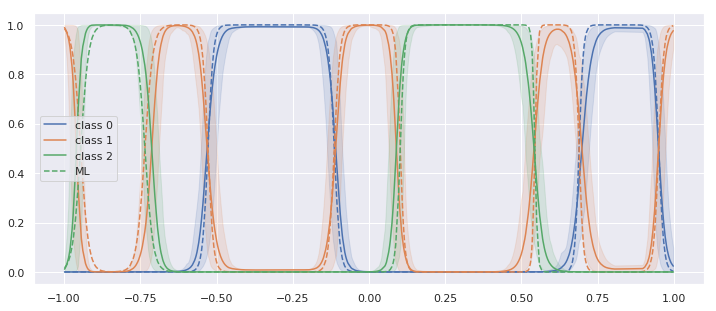

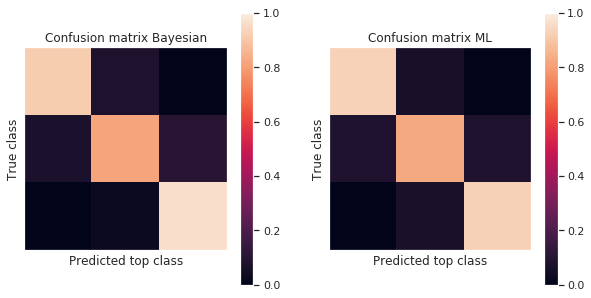

In [7]:
##### BAYESIAN MODEL

### Get classifier output for the whole dataset and for many samples of the last layer's weights
n_samples = 100       
with torch.no_grad():
    # Compute deterministic NN output
    h = features(x_test)
    cov_ab = flat_to_triangular(cov_ab_params)
    y_all = []
    for i in range(n_samples):
        # Sample last layer's weights from posterior q(a, b)
        ab_sample = stochastic(mu_ab, make_cholesky(logvar_ab, cov_ab))
        a, b = ab_sample[:-b_size], ab_sample[-b_size:]
        a = a.view(a_shape)
        b = b.unsqueeze(0)
        
        # Compute last layer output (the logits) with the weights just sampled
        y = h @ a + b    # shape: (N, n_classes)
        
        y_all.append(y.softmax(1).unsqueeze(0).cpu().numpy())

y_all = np.concatenate(y_all, axis=0)  # shape: (n_samples, N, n_classes)


### Get predictions (argmax) for all samples of weights (a,b)
pred_class = np.argmax(y_all, axis=-1)   # tensor of indices, shape (n_samples, N)
pred_class_onehot = onehot(pred_class)
pred_class_mean = pred_class_onehot.mean(0)   # shape (N, n_classes)
# pred_class_mean: for each input point a vector of size n_classes that sums to 1


### Get confusion matrix based on those samples
conf_matrix = np.zeros((n_classes, n_classes))
for i in range(N_test):
    conf_matrix[t_values_test[i]] += pred_class_mean[i]
conf_matrix /= conf_matrix.sum(1, keepdims=True)




##### ML MODEL

### Get classifier output for the whole dataset and for many samples of the last layer's weights
n_samples = 1       
with torch.no_grad():
    # Compute deterministic NN output
    h = ml_features(x_test)
    ml_y_all = []
    for i in range(n_samples):
        ab_sample = ml_mu_ab
        a, b = ab_sample[:-b_size], ab_sample[-b_size:]
        a = a.view(a_shape)
        b = b.unsqueeze(0)
        
        # Compute last layer output (the logits) with the weights just sampled
        y = h @ a + b    # shape: (N, n_classes)
        
        ml_y_all.append(y.softmax(1).unsqueeze(0).cpu().numpy())

ml_y_all = np.concatenate(ml_y_all, axis=0)  # shape: (n_samples, N, n_classes)


### Get predictions (argmax) for all samples of weights (a,b)
ml_pred_class = np.argmax(ml_y_all, axis=-1)   # tensor of indices, shape (n_samples, N)
ml_pred_class_onehot = onehot(ml_pred_class)
ml_pred_class_mean = ml_pred_class_onehot.mean(0)   # shape (N, n_classes)
# pred_class_mean: for each input point a vector of size n_classes that sums to 1


### Get confusion matrix based on those samples
ml_conf_matrix = np.zeros((n_classes, n_classes))
for i in range(N_test):
    ml_conf_matrix[t_values_test[i]] += ml_pred_class_mean[i]
ml_conf_matrix /= ml_conf_matrix.sum(1, keepdims=True)





###### PLOT STUFF

### Plot class probability outputs of the classifier (distribution over different samples of a,b)
y_lower = np.percentile(y_all, 5, axis=0)
y_upper = np.percentile(y_all, 95, axis=0)
y_mean = np.mean(y_all, axis=0)
ml_y_mean = np.mean(ml_y_all, axis=0)
x_numpy = x_test.detach().cpu().numpy().flatten()
plt.figure(figsize=(12, 5))
for c in range(n_classes):
    plot(x_numpy, y_mean[:, c], y_lower[:, c], y_upper[:, c], color=sns.color_palette()[c],
         alpha=0.15, title='90% interval of {} samples of (a, b)'.format(n_samples), xlabel='$x$', ylabel='$Pr(c | x, a, b)$', 
         label='class {}'.format(c))
    if c == n_classes-1:
        plot(x_numpy, ml_y_mean[:, c], color=sns.color_palette()[c], linestyle='--', label='ML')
    else:
        plot(x_numpy, ml_y_mean[:, c], color=sns.color_palette()[c], linestyle='--')
plt.show()


# ### Plot probability of selecting each class (argmax version of the previous plot) - maybe this is useless
# plt.figure(figsize=(12, 7))
# for c in range(n_classes):
#     plot(x_numpy, pred_class_mean[:, c], color=sns.color_palette()[c], title='prob of classification of {} samples of (a, b)'.format(n_samples), xlabel='$x$', ylabel='', 
#          label='class {}'.format(c))
# plt.show()


### Show confusion matrix
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(conf_matrix, vmin=0.0, vmax=1.0)
plt.colorbar()
plt.grid(False)
clean_curr_axes()
plt.title('Confusion matrix Bayesian')
plt.xlabel('Predicted top class')
plt.ylabel('True class')
plt.subplot(1, 2, 2)
plt.imshow(ml_conf_matrix, vmin=0.0, vmax=1.0)
plt.colorbar()
plt.grid(False)
clean_curr_axes()
plt.title('Confusion matrix ML')
plt.xlabel('Predicted top class')
plt.ylabel('True class')
plt.show()


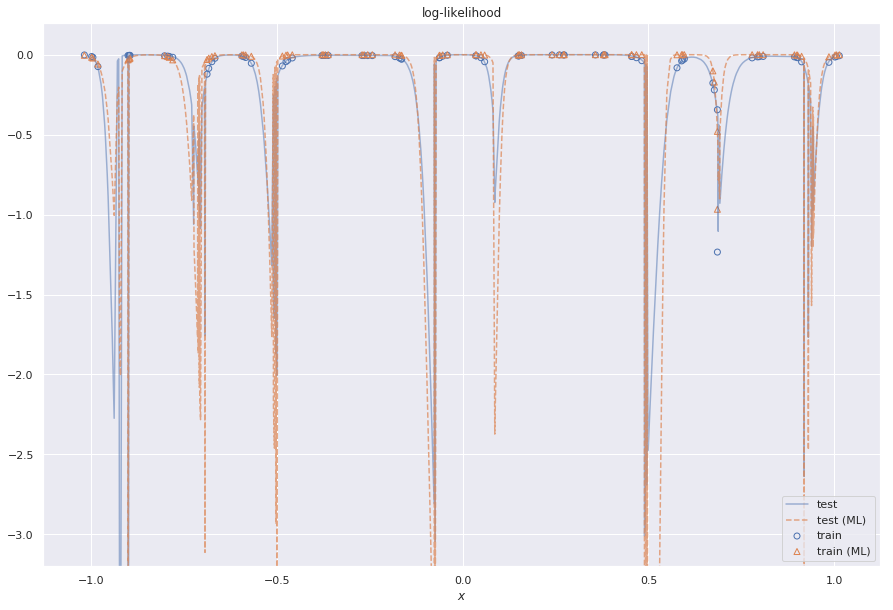

LL training set: -3.47
LL test set (rescaled Ntr/Ntest): -15
(ML) LL test set (rescaled Ntr/Ntest): -23.3


In [38]:
##### BAYESIAN MODEL

### Get classifier output for the whole dataset and for many samples of the last layer's weights
n_samples_test = 1000  # 100
recons_test = torch.zeros((n_samples_test, x_test.size(0)), device=x.device)
recons = torch.zeros((n_samples_test, x.size(0)), device=x.device)
recons_test_ml = torch.zeros((1, x_test.size(0)), device=x.device)
recons_ml = torch.zeros((1, x.size(0)), device=x.device)
with torch.no_grad():
    # Compute deterministic NN output
    h = features(x_test)
    cov_ab = flat_to_triangular(cov_ab_params)
    y_all = []   # test set
    for i in range(n_samples_test):
        # Sample last layer's weights from posterior q(a, b)
        ab_sample = stochastic(mu_ab, make_cholesky(logvar_ab, cov_ab))
        a, b = ab_sample[:-b_size], ab_sample[-b_size:]
        a = a.view(a_shape)
        b = b.unsqueeze(0)
        
        # Compute last layer output (the logits) with the weights just sampled
        y = h @ a + b    # shape: (N, n_classes)
        
        recons_test[i] = f.cross_entropy(y, t_values_test, reduction='none')
        y_all.append(y.softmax(1).unsqueeze(0).cpu().numpy())

    y_all = np.concatenate(y_all, axis=0)  # shape: (n_samples, N, n_classes)

    log_likelihood_test = (log_sum_exp(-recons_test, dim=0) - np.log(n_samples_test)).squeeze().detach().cpu().numpy()

    
    ## ML model
    h = ml_features(x_test)
    ab_sample = ml_mu_ab
    a, b = ab_sample[:-b_size], ab_sample[-b_size:]
    a = a.view(a_shape)
    b = b.unsqueeze(0)

    # Compute last layer output (the logits) with the weights just sampled
    y = h @ a + b    # shape: (N, n_classes)

    recons_test_ml[0] = f.cross_entropy(y, t_values_test, reduction='none')

    log_likelihood_test_ml = (log_sum_exp(-recons_test_ml, dim=0) - np.log(1)).squeeze().detach().cpu().numpy()

        
        
    # Compute deterministic NN output
    h = features(x)
    cov_ab = flat_to_triangular(cov_ab_params)
    for i in range(n_samples_test):
        # Sample last layer's weights from posterior q(a, b)
        ab_sample = stochastic(mu_ab, make_cholesky(logvar_ab, cov_ab))
        a, b = ab_sample[:-b_size], ab_sample[-b_size:]
        a = a.view(a_shape)
        b = b.unsqueeze(0)
        
        # Compute last layer output (the logits) with the weights just sampled
        y = h @ a + b    # shape: (N, n_classes)
        
        recons[i] = f.cross_entropy(y, t_values, reduction='none')

    log_likelihood = (log_sum_exp(-recons, dim=0) - np.log(n_samples_test)).squeeze().detach().cpu().numpy()

    
    ## ML model
    h = ml_features(x)
    cov_ab = flat_to_triangular(cov_ab_params)
    ab_sample = ml_mu_ab
    a, b = ab_sample[:-b_size], ab_sample[-b_size:]
    a = a.view(a_shape)
    b = b.unsqueeze(0)

    # Compute last layer output (the logits) with the weights just sampled
    y = h @ a + b    # shape: (N, n_classes)

    recons_ml[0] = f.cross_entropy(y, t_values, reduction='none')

    log_likelihood_ml = (log_sum_exp(-recons_ml, dim=0) - np.log(1)).squeeze().detach().cpu().numpy()


x_test_numpy = x_test.detach().cpu().numpy().flatten()
x_numpy = x.detach().cpu().numpy().flatten()
plt.figure(figsize=(15, 10))
plt.scatter(x_numpy, log_likelihood, label='train', color=sns.color_palette()[0], facecolors='none')
plt.scatter(x_numpy, log_likelihood_ml, label='train (ML)', color=sns.color_palette()[1], facecolors='none', marker='^')
plot(x_test_numpy, log_likelihood_test, title='log-likelihood', label='test', line_alpha=0.5, xlabel='$x$')
plot(x_test_numpy, log_likelihood_test_ml, title='log-likelihood', label='test (ML)', line_alpha=0.7, linestyle='--', xlabel='$x$')
plt.ylim([-3.2, .2])
plt.show()

# TODO check these
print("LL training set: {:.3g}".format(log_likelihood.sum()))
print("LL test set (rescaled Ntr/Ntest): {:.3g}".format(log_likelihood_test.mean()*N))
print("(ML) LL test set (rescaled Ntr/Ntest): {:.3g}".format(log_likelihood_test_ml.mean()*N))

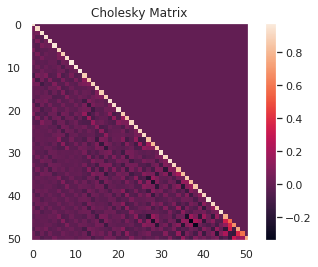

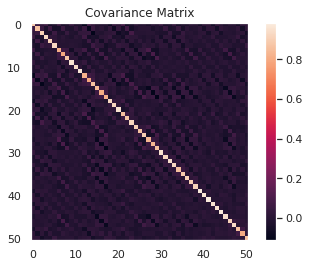

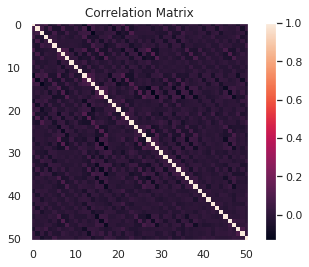

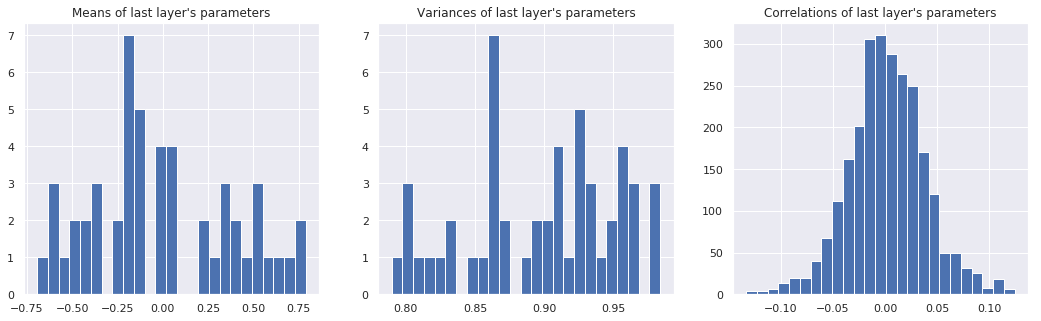

In [9]:
L = make_cholesky(logvar_ab, cov_ab).detach().cpu().numpy()
Cov = L @ L.T
inv_stds = np.diag(np.diag(Cov)**(-0.5))
Corr = inv_stds @ Cov @ inv_stds

plt.title("Cholesky Matrix"), plt.grid(False)
plt.imshow(L)
plt.colorbar()
plt.show()

plt.title("Covariance Matrix"), plt.grid(False)
plt.imshow(Cov)
plt.colorbar()
plt.show()

plt.title("Correlation Matrix"), plt.grid(False)
plt.imshow(Corr)
plt.colorbar()
plt.show()

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.title("Means of last layer's parameters")
plt.hist(mu_ab.detach(), bins=25)
plt.subplot(1, 3, 2)
plt.title("Variances of last layer's parameters")
plt.hist(np.diag(Cov), bins=25)
plt.subplot(1, 3, 3)
plt.title("Correlations of last layer's parameters")  # corr coefficients between pairs of DIFFERENT variables
correlations = Corr[~np.eye(Corr.shape[0], dtype=bool)]
plt.hist(correlations, bins=25)
plt.show()

### Interpreting outputs as probabilities?

_We don't need to keep this section, it's kind of an exploration._

The output of classifiers is a probability distribution. We want to see if such probabilities are actually reflected in accuracy. A simple way of doing this is to take all test samples that are classified with probability in some interval (e.g. 90-95% or 98-100%) and measure the actual classifier's accuracy on those samples. In principle (justify it in theory?) we expect it to match the classifier's "confidence".

It's a bit hard to do depending on the data set. For example if the model can classify the data points pretty easily, the probability assigned by the classifier will usually be very high, so only the intervals of probability close to 1 will have enough examples to give a reliable estimate (see plot below, "data points per bin").

y all: (1000, 1000, 3)
y all (ML): (1, 1000, 3)
y_max_prob_mean: (1000,)
y_max_prob_mean (ML): (1000,)
y max class: (1000,)
y max class (ML): (1000,)


 -- Distribution of classifier probability for each class:


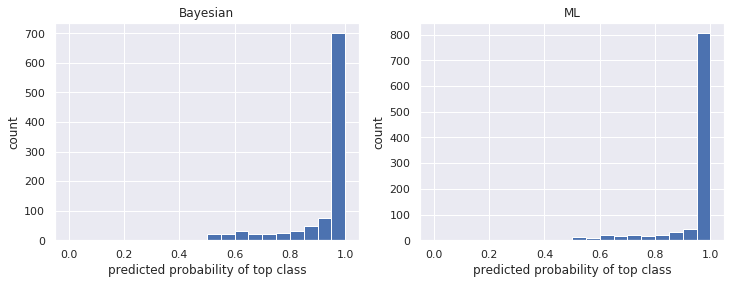

The probabilities on the x-axis are the expectation wrt q(a,b), 1000 samples


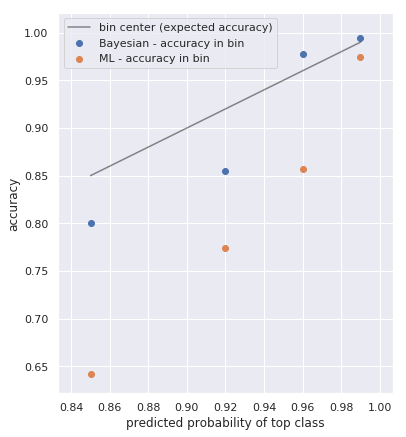

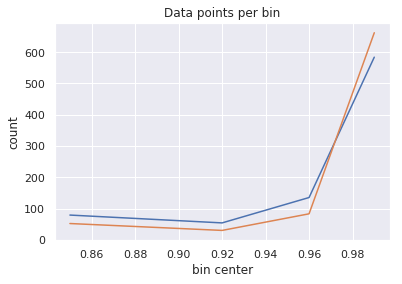

In [10]:
print('y all:', y_all.shape)  # shape (n_samples, N_test, n_classes)
print('y all (ML):', ml_y_all.shape)  # shape (n_samples, N_test, n_classes)

# # Get argmax for each data point and for each sample q(a, b)
# y_max = np.argmax(y_all, axis=-1)  # shape (n_samples, N_test)
# print('y max:', y_max.shape)

# Get expected (wrt q(a, b)) classifier probabilities P(c | x, a, b) for each data point,
# then pick the highest one for each data points.
# max_c {E_q(a,b) [P(c | x_i, a, b)]}
y_max_prob_mean = y_all.mean(0).max(axis=-1)    # shape N_test
print('y_max_prob_mean:', y_max_prob_mean.shape)
ml_y_max_prob_mean = ml_y_all.mean(0).max(axis=-1)    # shape N_test
print('y_max_prob_mean (ML):', y_max_prob_mean.shape)

# Get argmax of probability for each data point, using expected probabilities wrt q(a, b)
# i.e. the index of the max probabilities we just computed above
y_max_class = np.argmax(y_all.mean(0), axis=-1)  # shape N_test
print('y max class:', y_max_class.shape)
ml_y_max_class = np.argmax(ml_y_all.mean(0), axis=-1)  # shape N_test
print('y max class (ML):', y_max_class.shape)

print('\n\n -- Distribution of classifier probability for each class:')
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title('Bayesian')
plt.xlabel('predicted probability of top class'), plt.ylabel('count')
plt.hist(y_max_prob_mean, bins=np.linspace(0., 1., 21))
plt.subplot(1, 2, 2)
plt.title('ML')
plt.xlabel('predicted probability of top class'), plt.ylabel('count')
plt.hist(ml_y_max_prob_mean, bins=np.linspace(0., 1., 21))
plt.show()
print('The probabilities on the x-axis are the expectation wrt q(a,b), {} samples'.format(y_all.shape[0]))

# bins = np.arange(0.8, 1.0 + 1e-3, 0.05)
bins = np.array([0.8, 0.9, 0.94, 0.98, 1.0])
bins_avg = (bins[:-1] + bins[1:]) / 2
accuracies = np.zeros_like(bins_avg)
n_data_points = np.zeros_like(bins_avg)
accuracies_ml = np.zeros_like(bins_avg)
n_data_points_ml = np.zeros_like(bins_avg)
for i in range(len(bins) - 1):
    t_values_test_np = t_values_test.detach().cpu().numpy()
    pred_class = y_max_class
    pred_class_ml = ml_y_max_class
    ix = np.logical_and((y_max_prob_mean > bins[i]), y_max_prob_mean < bins[i+1])
    ix_ml = np.logical_and((ml_y_max_prob_mean > bins[i]), ml_y_max_prob_mean < bins[i+1])
    accuracies[i] = np.mean((t_values_test_np[ix]==pred_class[ix]))
    accuracies_ml[i] = np.mean((t_values_test_np[ix_ml]==pred_class_ml[ix_ml]))
    n_data_points[i] = np.count_nonzero(ix)
    n_data_points_ml[i] = np.count_nonzero(ix_ml)
    
plt.figure(figsize=(6, 7))
plt.scatter(bins_avg, accuracies, label='Bayesian - accuracy in bin')
plt.scatter(bins_avg, accuracies_ml, label='ML - accuracy in bin')
plt.plot(bins_avg, bins_avg, color='k', alpha=0.5, label='bin center (expected accuracy)')
plt.legend()
plt.xlabel('predicted probability of top class')
plt.ylabel('accuracy')
plt.show()

plt.title('Data points per bin')
plt.plot(bins_avg, n_data_points, label='bayesian')
plt.plot(bins_avg, n_data_points_ml, label='ML')
plt.xlabel('bin center'), plt.ylabel('count')
plt.show()

# Key points

* Bayesian model seems not to overfit 
* same accuarcy but better likelihood => better uncertainty?
